# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) although we have taken steps to pull this data into a publis s3 bucket: `s3://sta9760-yelpdataset/yelp-light/*business.json`

# Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [1]:
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("seaborn==0.10.0")
sc.install_pypi_package("scipy==1.4.1")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1588521981378_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Importing

Now, import the installed packages from the previous block below.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

We are finally ready to load data. Using `spark` load the data from S3 into a `dataframe` object that we can manipulate further down in our analysis.

In [3]:
df = spark.read.json('s3://sta9760-spark-datasets2/*business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
df.head(1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(address='10913 Bailey Rd', attributes=Row(AcceptsInsurance=None, AgesAllowed=None, Alcohol=None, Ambience=None, BYOB=None, BYOBCorkage=None, BestNights=None, BikeParking='True', BusinessAcceptsBitcoin=None, BusinessAcceptsCreditCards='True', BusinessParking="{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}", ByAppointmentOnly='False', Caters=None, CoatCheck=None, Corkage=None, DietaryRestrictions=None, DogsAllowed=None, DriveThru=None, GoodForDancing=None, GoodForKids='False', GoodForMeal=None, HairSpecializesIn=None, HappyHour=None, HasTV=None, Music=None, NoiseLevel=None, Open24Hours=None, OutdoorSeating=None, RestaurantsAttire=None, RestaurantsCounterService=None, RestaurantsDelivery=None, RestaurantsGoodForGroups=None, RestaurantsPriceRange2='3', RestaurantsReservations=None, RestaurantsTableService=None, RestaurantsTakeOut=None, Smoking=None, WheelchairAccessible=None, WiFi=None), business_id='f9NumwFMBDn751xgFiRbNA', categories='Active Life

## Overview of Data

Display the number of rows and columns in our dataset.

In [5]:
print(f'Total Columns: {len(df.dtypes)}')
print(f'Total Rows: {df.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 14
Total Rows: 209,393

Display the DataFrame schema below.

In [6]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

In [7]:
df.createOrReplaceTempView('yelp')

sqldf = spark.sql(
'''
SELECT `business_id`,`name`,`city`,`state`,`stars`,`categories` FROM yelp
limit 5
'''
)
sqldf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----------+-----+-----+--------------------+
|         business_id|                name|       city|state|stars|          categories|
+--------------------+--------------------+-----------+-----+-----+--------------------+
|2utGLjz9HlhK6QqPO...|         Tim Hortons|    Vaughan|   ON|  2.0|Breakfast & Brunc...|
|yyvWWWGuoMWyINaOf...|Pas D'cochon Dans...|   Montréal|   QC|  4.0|   Food, Food Trucks|
|2k-ki66QUs1xJcPqG...|       Haulin' Goats|Valley City|   OH|  3.5|Pets, Pet Service...|
|RsTqIM3xfeaWybqmF...|       The Mutt Hutt|  Cleveland|   OH|  4.5|Pet Services, Pet...|
|3lD7zRNc4h4aGGBRr...|Sleep Well Las Vegas|  Las Vegas|   NV|  4.5|Shopping, Mattres...|
+--------------------+--------------------+-----------+-----+-----+--------------------+

# Analyzing Categories

Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [8]:
#first select business_id and categories 
sqldf2 = spark.sql(
'''
SELECT business_id,categories FROM yelp
'''
)
sqldf2.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|         business_id|          categories|
+--------------------+--------------------+
|f9NumwFMBDn751xgF...|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|Health & Medical,...|
|XNoUzKckATkOD1hP6...|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|Home Services, Pl...|
+--------------------+--------------------+
only showing top 5 rows

In [9]:
from pyspark import Row
from pyspark.sql import SQLContext
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
from pyspark.sql.functions import regexp_replace,col

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
#remove the space between letter and comma for easier split by comma in the next cell
sqldf2_new = sqldf2.select(sqldf2["business_id"],regexp_replace(col("categories")," ","").alias("categories"))
sqldf2_new.show(5)
#below is the categories after removing extra space

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|         business_id|          categories|
+--------------------+--------------------+
|f9NumwFMBDn751xgF...|ActiveLife,Gun/Ri...|
|Yzvjg0SayhoZgCljU...|Health&Medical,Fi...|
|XNoUzKckATkOD1hP6...|Pets,PetServices,...|
|6OAZjbxqM5ol29BuH...|HardwareStores,Ho...|
|51M2Kk903DFYI6gnB...|HomeServices,Plum...|
+--------------------+--------------------+
only showing top 5 rows

Display the first 5 rows of your association table below.

In [11]:
#split the categories by cell and put them into different rows
sqldf2_new = sqldf2_new.withColumn("categories",explode(split("categories","[,]")))
sqldf2_new.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------------+
|         business_id|     categories|
+--------------------+---------------+
|f9NumwFMBDn751xgF...|     ActiveLife|
|f9NumwFMBDn751xgF...|Gun/RifleRanges|
|f9NumwFMBDn751xgF...|      Guns&Ammo|
|f9NumwFMBDn751xgF...|       Shopping|
|Yzvjg0SayhoZgCljU...| Health&Medical|
+--------------------+---------------+
only showing top 5 rows

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [12]:
sqldf4 = sqldf2_new.groupBy('categories').count().orderBy('count',ascending=False)
print(f'Total number of unique categories {sqldf4.count()}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total number of unique categories 1336

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [13]:
sqldf4.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|          categories|count|
+--------------------+-----+
|         Restaurants|63944|
|            Shopping|34644|
|                Food|32991|
|        HomeServices|22487|
|         Beauty&Spas|20520|
|      Health&Medical|19227|
|       LocalServices|15783|
|          Automotive|14720|
|           Nightlife|14211|
|                Bars|12400|
|EventPlanning&Ser...|11263|
|          ActiveLife|10225|
|          Coffee&Tea| 8415|
|             Fashion| 8374|
|            FastFood| 8106|
|          Sandwiches| 8064|
|American(Traditio...| 7596|
|         Home&Garden| 7331|
|          HairSalons| 7303|
|               Pizza| 7302|
+--------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [14]:
pdf_plot = sqldf4.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

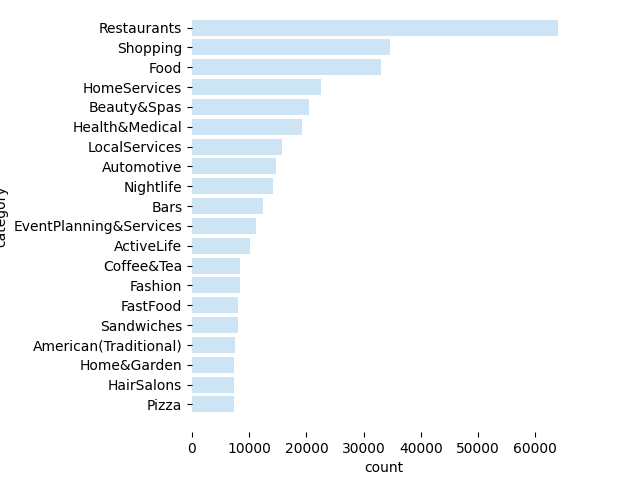

In [15]:
plt.figure()
pdf_plot2 = pdf_plot[0:20]
pdf_plot2 = pdf_plot2[::-1]
ax1 = plt.axes([0.3,0.1,0.6,0.9])
ypos = np.arange(20)
ax1.barh(ypos,pdf_plot2['count'],color='#007acc', alpha=0.2)
plt.yticks(ypos, pdf_plot2['categories'])

ax1.set_title('Top Categories by Business')
ax1.set_ylabel('category')
ax1.set_xlabel('count')
plt.box(False)
ax1.spines['top'].set_color('none')
ax1.spines['right'].set_color('none')
ax1.spines['left'].set_smart_bounds(True)
ax1.spines['bottom'].set_smart_bounds(True)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

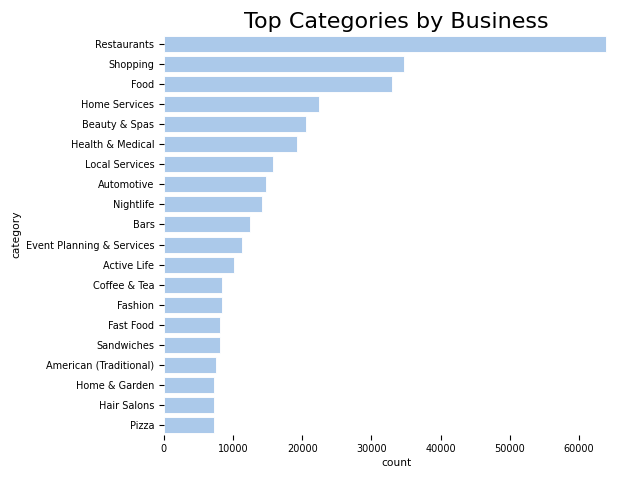

In [15]:
#original figure from professor for comparison

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely _dissatisfied_ or extremely _satisfied_ with the service received. 

How true is this really? Let's try and answer this question.

## Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [16]:
df_review = spark.read.json('s3://sta9760-spark-datasets2/*review.json')
df_review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the `business_id` and `stars` columns together for the user reviews data.

In [17]:
df_review.createOrReplaceTempView('review')

sqldf_review = spark.sql(
'''
SELECT `business_id`,`stars` FROM review

'''
)
sqldf_review.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [18]:
sqldf_review2 = spark.sql(
'''
SELECT
  business_id,
  AVG(stars) as avg
FROM review
GROUP BY business_id
'''
)
sqldf_review2.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|               avg|
+--------------------+------------------+
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vQGZjrDiDBuznOkUe...| 4.454545454545454|
|vyu1WGlnHGv2Z2MVE...|               5.0|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [19]:
sqldf_review2.createOrReplaceTempView("review_avg")
sqldf_review3 = spark.sql(
'''
SELECT
  review_avg.avg,
  yelp.stars,
  yelp.name,
  yelp.city,
  yelp.state
FROM review_avg
Join yelp 
on review_avg.business_id=yelp.business_id
'''
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's see a few of these:

In [20]:
sqldf_review3.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+-----------+-----+
|               avg|stars|                name|       city|state|
+------------------+-----+--------------------+-----------+-----+
|  4.11784140969163|  4.0|Delmonico Steakhouse|  Las Vegas|   NV|
|2.3333333333333335|  2.5|Neo-Paws Internat...|    Toronto|   ON|
|             4.375|  4.5| McFarling Law Group|  Las Vegas|   NV|
|3.3333333333333335|  3.5|Volvo of Mississauga|Mississauga|   ON|
|               5.0|  5.0|Andre Agassi Coll...|  Las Vegas|   NV|
+------------------+-----+--------------------+-----------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [21]:
sqldf_review3.createOrReplaceTempView("review_skew")
sqldf_review4 = spark.sql(
'''
SELECT
  (avg-stars)/stars as skew
FROM review_skew

'''
)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And finally, graph it!

In [22]:
plt.figure()
review_plot = sqldf_review4.toPandas()
num_bins=100
density = sp.stats.gaussian_kde(review_plot['skew'])
n,x,_=plt.hist(review_plot['skew'], num_bins, color='#007acc', alpha=0.2, density=True)
plt.plot(x,density(x))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

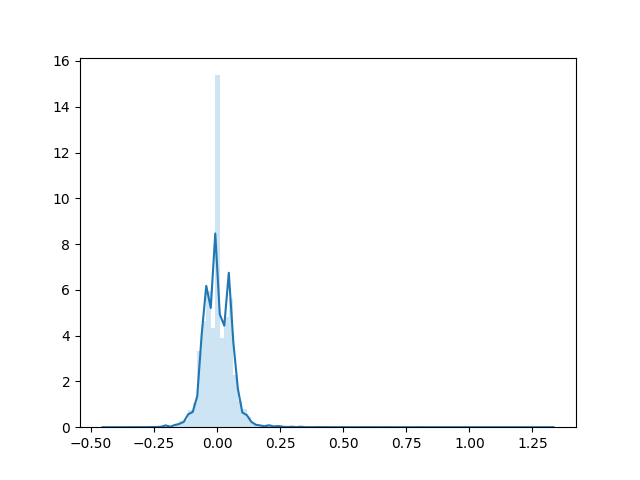

In [23]:
%matplot plt

In [24]:
from scipy.stats import skew 
skew(review_plot['skew'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1.336506951503129

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph. 

## Analysis:
Yes, the Yelp written Reviews skews negative. The plot above shows more weight in the left side of the distribution which is negative.

Also, I calculate the skewness of the distribution, which is 1.34. And it confirms that the left tail is heavier than the right tail.

It somehow reflect that Yelp users who write reviews are generally more critical, and give lower stars comparing to general users.

# Additiondal Work For Part III

In [56]:
#select star and other three ratings data
sqldf_review_additional = spark.sql(
'''
SELECT stars,useful,funny,cool FROM review

'''
)
sqldf_review_additional.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+------+-----+----+
|stars|useful|funny|cool|
+-----+------+-----+----+
|  2.0|     5|    0|   0|
|  1.0|     1|    1|   0|
|  5.0|     1|    0|   0|
|  1.0|     0|    0|   0|
|  4.0|     0|    0|   0|
+-----+------+-----+----+
only showing top 5 rows

In [57]:
additional_plot = sqldf_review_additional.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Is High Star Rating More Useful?

The figure below shows that actually reviews which give low star rating are on average considered more useful. This is probably that these reviews tend to reveal really bad service and business and thus are consider more helpful for other users so they can avoid these business.

In [87]:
t1=additional_plot.groupby(['stars']).mean()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [96]:
t1.plot()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

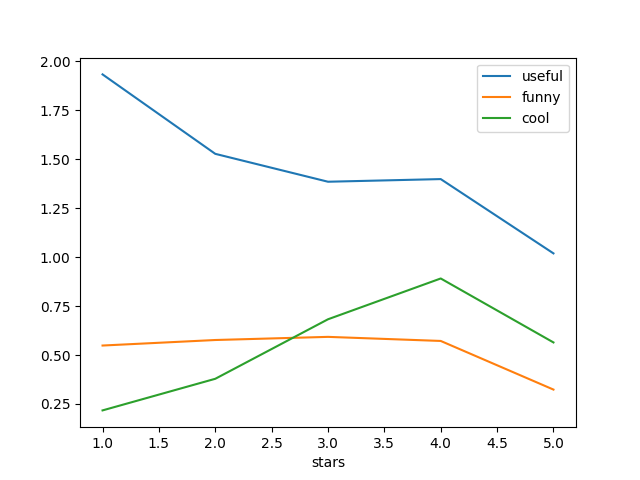

In [97]:
%matplot plt

# Is There Correlation Between funny and cool Review?

The scatter plot below shows that there is not very clear correlation beteewn cool and funny attribute of a review, which means funny review are not necessarily considered cool.

However, in the region of review having 0-200 funny count, the number of cool it receives show a weakly positive correlation of the number of funny it receives. So in this region, funnier review usually are cooler also.

In [64]:
additional_plot.plot.scatter(x='funny',y='cool')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

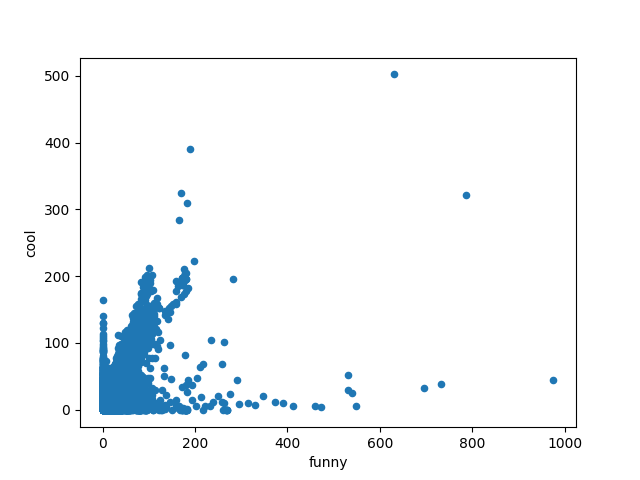

In [65]:
%matplot plt

# Should the Elite be Trusted? (Or, some other analysis of your choice)

For the final portion - you have a choice:

* Try and analyze some interesting dimension to this data. The **ONLY** requirement is that you must use the **Users** dataset and join on either the **business* or **reviews** dataset
* Or, you may try and answer the question posed: how accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating.

Feel free to use any and all methodologies at your disposal - only requirement is you must render one visualization in your analysis

In [70]:
df_user = spark.read.json('s3://sta9760-spark-datasets2/*user.json')
df_user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [72]:
#show some elite user examples
df_user.createOrReplaceTempView('user')

sqldf_user_elite = spark.sql(
'''
SELECT elite FROM user
where elite <> ''

'''
)
sqldf_user_elite.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|               elite|
+--------------------+
|2008,2009,2010,20...|
|                2010|
|                2009|
|2009,2010,2011,20...|
|                2007|
+--------------------+
only showing top 5 rows

In [73]:
#how many elite users
sqldf_user_elite.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

75961

In [74]:
#join review data table and user data table
sqldf_review_elite = spark.sql(
'''
SELECT
  review.stars,
  review.business_id,
  user.elite
FROM review
Join user
on review.user_id = user.user_id
'''
)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [75]:
sqldf_review_elite.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+--------------------+--------------------+
|stars|         business_id|               elite|
+-----+--------------------+--------------------+
|  4.0|pmrHuQiy25xKB86tb...|                    |
|  2.0|QhwaGi1niDeVEHMRt...|                    |
|  4.0|L772e6l2Yd0DJEyCB...|2011,2012,2013,20...|
|  5.0|aNe8ofTYrealxqv7V...|                    |
|  1.0|sAS4fHDiK8A9a1wEA...|                    |
+-----+--------------------+--------------------+
only showing top 5 rows

In [78]:
#filter user with elite status and calculate the average review star from these user
sqldf_review_elite.createOrReplaceTempView('review_elite')
sqldf_avg_elite = spark.sql(
'''
with user_elite as(
  select 
      business_id,
      stars,
      elite
  from review_elite
  WHERE elite <> ''
  )
SELECT
  business_id,
  AVG(stars) as avg
FROM user_elite
GROUP BY business_id
'''
)
sqldf_avg_elite.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|               avg|
+--------------------+------------------+
|OyhCNhJJuJjUt2avx...| 3.282051282051282|
|ipFreSFhjClfNETuM...|3.0588235294117645|
|eKznX8VTfcQrjCqXp...| 4.268817204301075|
|--9e1ONYQuAa-CB_R...|4.1916058394160585|
|-r8SvItXXG6_T3mP5...|               3.5|
+--------------------+------------------+
only showing top 5 rows

In [79]:
#join the average star table from elite user with yelp general business data
sqldf_avg_elite.createOrReplaceTempView("elite_avg")
sqldf_avg_elite_join = spark.sql(
'''
SELECT
  elite_avg.avg,
  yelp.stars,
  yelp.name
FROM elite_avg
Join yelp 
on elite_avg.business_id=yelp.business_id
'''
)
sqldf_avg_elite_join.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+
|               avg|stars|                name|
+------------------+-----+--------------------+
| 3.282051282051282|  3.0|       Chocolate Bar|
|3.0588235294117645|  2.5|  Doogan's of Aurora|
| 4.268817204301075|  4.5|                Rasa|
|4.1916058394160585|  4.0|Delmonico Steakhouse|
|               3.5|  4.0| Western Coffee Shop|
+------------------+-----+--------------------+
only showing top 5 rows

In [80]:
#calculate skew data for the elite users' average review star
sqldf_avg_elite_join.createOrReplaceTempView("elite_join")
sqldf_elite_skew = spark.sql(
'''
SELECT
  (avg-stars)/stars as skew
FROM elite_join
'''
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
plt.figure()
elite_plot = sqldf_elite_skew.toPandas()
num_bins=100
density = sp.stats.gaussian_kde(elite_plot['skew'])
n,x,_=plt.hist(elite_plot['skew'], num_bins, color='#007acc', alpha=0.2, density=True)
plt.plot(x,density(x))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

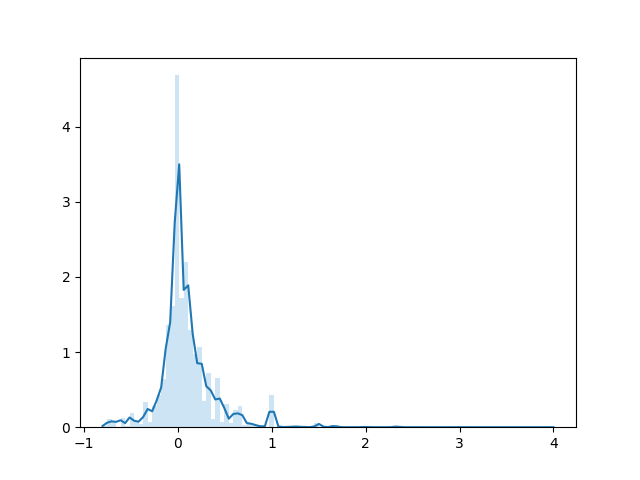

In [82]:
%matplot plt

In [83]:
skew(elite_plot['skew'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1.532764995870416

## Analysis

From the plot above, it shows skew data has more weight in the left side of the distribution. Also, the skewness statistics is 1.53 which is positive, so it means left tail is heavier. Both results suggest that on average elite users lower star rating than general user. Probably because elite users are more critical